In [1]:
import os
import sys
import pickle
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from skimage.filters import threshold_otsu
import tcripser
import gudhi,gudhi.hera,gudhi.wasserstein,persim

In [2]:
inDir="Z:/data/diverse_metals"
topTypes=os.listdir(inDir+"/diverseTop")
fName="DB0-m2_o19_nog_PH.npy"
#fName="DB1-Cu2O8N2-DPAC_A-irmof8_A_No668_PH.npy"
#diags=np.load(f"{inDir}/diverseTop/{topTypes[1]}/{fName}",allow_pickle=True)

In [3]:

df=pd.read_csv(f"{inDir}/post-combustion-vsa-2-clean.csv",index_col=0)
mofNames=list(df.index)
cols=df.columns #[wc,sel]

diags=np.load(f"{inDir}/diverseTop/{topTypes[1]}/{mofNames[0]}_PH.npy",allow_pickle=True)

In [ ]:
fName="DB1-Cu2O8N2-DPAC_A-irmof8_A_No668_PH.npy"
diags=np.load(f"{inDir}/diverseTop/{topTypes[1]}/{fName}",allow_pickle=True)

In [32]:
diags[0]

array([[-8.660254037844387, -8.602325267042627],
       [-8.48528137423857, -7.280109889280518],
       [-6.782329983125268, -6.6332495807108],
       [-7.0710678118654755, -6.48074069840786],
       [-7.0, -6.324555320336759],
       [-6.6332495807108, -6.324555320336759],
       [-7.280109889280518, -6.164414002968976],
       [-6.082762530298219, -6.0],
       [-7.0, -6.0],
       [-7.483314773547883, -5.385164807134504],
       [-7.810249675906654, -5.385164807134504],
       [-5.196152422706632, -5.0990195135927845],
       [-5.196152422706632, -5.0990195135927845],
       [-5.196152422706632, -5.0990195135927845],
       [-5.0990195135927845, -4.898979485566356],
       [-5.0, -4.898979485566356],
       [-5.0, -4.898979485566356],
       [-5.0, -4.69041575982343],
       [-5.0990195135927845, -4.58257569495584],
       [-4.58257569495584, -4.47213595499958],
       [-5.196152422706632, -4.47213595499958],
       [-4.58257569495584, -4.47213595499958],
       [-6.708203932499369,

### New one for a frequency projection -- one more layer of dictionary

In [35]:
class PDhash():
    def __init__(self,res=1,diags=None, maxHdim=2,persistThresh=0):
        """upper bound resolution.
        In the case of sparce PD spaces, it may be useful to project a hash map of your dataset to the diagram space"""
        self.res=res
        self.maxD=maxHdim
        self.thresh=persistThresh
        self.bounds=[[np.inf,-np.inf] for b in range(maxHdim+1)]
        self.img={b:dict() for b in range(maxHdim+1)} # While this does impose extra time compared to np, it is ideal for map-reduce type parallelization




    def addDiagRpp(self,diag,index): ## note the index can be just an index number, or a numerical value
                                    ###although the numerical values (duplicate index) won't stack in the set
        """diag is {0:[(b,d),...],1: """
        for i in range(np.min([self.maxD+1,len(diag)])):
            for k in diag[i]:
                if k[1]-k[0] >self.thresh:
                    pt=(round(k[0]/self.res)*self.res,round(k[1]/self.res)*self.res)
                    if pt[0]<self.bounds[i][0]:
                        self.bounds[i][0]=pt[0]
                    if pt[1]>self.bounds[i][1]:
                        self.bounds[i][1]=pt[1]
                    if pt in self.img[i]:
                        if index in self.img[i][pt]:
                            self.img[i][pt][index]+=1
                        else:
                            self.img[i][pt][index]=1

                    else:
                        self.img[i][pt]={index:1}

    def addDiagCubeRips(self,crispy,index):
        """diag is [[bi,b,d,bx,by,bz,dx,dy,dz],..] """
        pass

    def __getitem__(self, item):
        if type(item)==int: #item is bi
            return self.img[item]
        else:
            #return {b:self.img[b][pt] for b in range(self.maxD) for pt in self.img[b].keys()}
            return {b:self.img[b][tuple(item)] for b in range(self.maxD) if tuple(item) in self.img[b]}

    #def indexImgMap(self,fn=lambda pt: np.sum([v*k for k,v in self.img])): #assuming index is something numerically useful like a property assocated to each PD

    def mean_to_numpy(self,bi=None):
        roundDig=8
        if type(bi)==int and bi<=self.maxD:
            mi,ma=self.bounds[bi]
            life=int((self.bounds[bi][1]-self.bounds[bi][0])/self.res + 1)
            meanBox=np.zeros((life,life),dtype='float32')

            for k,v in self.img[bi].items():
                if type(v)==dict:
                    meanBox[int((ma-k[1])/self.res),int((k[0]-mi)/self.res)]=np.round(np.sum([t*p for p,t in v.items()])/np.sum([t for p,t in v.items()]),roundDig)
                else:
                    meanBox[int((ma-k[1])/self.res),int((k[0]-mi)/self.res)]=np.round(np.mean(list(v)),roundDig)
            return meanBox


In [24]:
def boxStatsIndex(pdStack):
    return {b:{pt:(np.mean(np.array(list(pdStack[b][pt]),dtype=np.float32)),np.var(np.array(list(pdStack[b][pt]),dtype=np.float32))) for pt in pdStack[b].keys()} for b in pdStack.img.keys()}

def mean_to_numpy(pdStack,bi=None):
    roundDig=8
    if type(bi)==int and bi<=pdStack.maxD:
        mi,ma=pdStack.bounds[bi]
        life=int((pdStack.bounds[bi][1]-pdStack.bounds[bi][0])/pdStack.res + 1)
        meanBox=np.zeros((life,life),dtype='float32')

        for k,v in pdStack.img[bi].items():
            if type(v)==dict:
                meanBox[int((ma-k[1])/pdStack.res),int((k[0]-mi)/pdStack.res)]=np.round(np.sum([t*p for p,t in v.items()])/np.sum([t for p,t in v.items()]),roundDig)
            else:
                meanBox[int((ma-k[1])/pdStack.res),int((k[0]-mi)/pdStack.res)]=np.round(np.mean(list(v)),roundDig)
        return meanBox



In [34]:
pdStack=PDhash(res=1,diags=None, maxHdim=2,persistThresh=1)



In [36]:
pdStack=PDhash(res=1,diags=None, maxHdim=2,persistThresh=1)
# stack in terms of index number for mofNames, then we can try selectivities and workcap images
topType=topTypes[0]
for i in range(len(mofNames)):
    try:
        pdStack.addDiagRpp(np.load(f"{inDir}/diverseTop/{topType}/{mofNames[i]}_PH.npy",allow_pickle=True),i)
    except:
        print(f"error with \t {mofNames[i]}")

In [37]:
pdStack.bounds

[[-152, 18], [-72, 21], [-73, 26]]

pdStackCap=PDhash(res=1,diags=None, maxHdim=2,persistThresh=1)
for i in range(len(mofNames)):
    try:
        pdStackCap.addDiagRpp(np.load(f"{inDir}/diverseTop/{topTypes[1]}/{mofNames[i]}_PH.npy",allow_pickle=True),df.iloc[i][0])
    except:
        print(f"error with \t {mofNames[i]}")

In [38]:

#another (quicker) way to project without rereading all PDs
#maybe make this a function
pdStackSel=PDhash(res=pdStack.res,diags=None, maxHdim=pdStack.maxD,persistThresh=pdStack.thresh)
pdStackSel.bounds=pdStack.bounds
pdStackSel.img={b:{pt:{df.loc[mofNames[i]][1] for i in pdStack.img[b][pt]} for pt in pdStack.img[b].keys()} for b in pdStack.img.keys()}


In [39]:
pdStackCap=PDhash(res=pdStack.res,diags=None, maxHdim=pdStack.maxD,persistThresh=pdStack.thresh)
pdStackCap.bounds=pdStack.bounds
pdStackCap.img={b:{pt:{df.loc[mofNames[i]][0] for i in pdStack.img[b][pt]} for pt in pdStack.img[b].keys()} for b in pdStack.img.keys()}

In [40]:

with open(f"{inDir}/diverseTopPDhash/pdStack_freq_{topType}.pkl","wb") as f:
    pickle.dump(pdStack,f)

with open(f"{inDir}/diverseTopPDhash/pdStackCap_freq_{topType}.pkl","wb") as f:
    pickle.dump(pdStackCap,f)

with open(f"{inDir}/diverseTopPDhash/pdStackSel_freq_{topType}.pkl","wb") as f:
    pickle.dump(pdStackSel,f)

In [89]:
with open(f"{inDir}/diverseTopPDhash/pdStack_{topType}_freq.pkl","wb") as f:
    pickle.dump(pdStack,f)

In [43]:
df.loc['DB0-m3_o12_o22_f0_pcu.sym.90']

mmol/g_working_capacity     0.370563
selectivity                13.582315
Name: DB0-m3_o12_o22_f0_pcu.sym.90, dtype: float64

In [41]:
pdStack.bounds

[[-152, 18], [-72, 21], [-73, 26]]

In [88]:
pdStack[(-90,4)]

{0: {12157: 1}, 1: {12149: 2}}

In [75]:
[(k,pdStackCap.img[0][k]) for k in pdStackCap.img[0].keys() if -150<k[0]<-130 and 1>k[1]>-3]

[((-139, -2),
  {0.254133,
   0.491565,
   0.514077,
   0.58798,
   0.682462,
   0.786387,
   1.04067,
   1.537087,
   1.693052,
   1.837884,
   2.673833,
   3.348225,
   3.373457}),
 ((-137, 0),
  {0.003872,
   0.023425,
   0.191077,
   0.216487,
   0.485485,
   0.539053,
   0.678595,
   0.686387,
   0.796174,
   1.097857,
   1.124381,
   1.327808}),
 ((-140, -2),
  {0.107121,
   0.514077,
   0.599805,
   0.845073,
   1.04067,
   1.328542,
   1.333084,
   1.603684,
   1.627082,
   1.647932,
   2.275248,
   2.39825,
   2.610907,
   2.818308}),
 ((-134, -2), {0.845073, 1.316922, 1.603684, 1.787347, 2.417968}),
 ((-141, -2),
  {0.599805,
   0.845073,
   0.861284,
   1.04067,
   1.253316,
   1.472302,
   1.603684,
   1.642597,
   1.753883,
   2.254561,
   2.366659,
   2.481336,
   2.502609,
   2.770424,
   2.947436,
   2.949012,
   3.373457,
   3.514491,
   3.744637,
   3.969893,
   5.134054}),
 ((-136, -2), {1.603684, 3.514491}),
 ((-133, -1), {0.323367, 0.845073, 1.100136, 1.145526, 1.8

In [128]:
pdStackCap[2]

{(3, 4): {0.637791,
  0.44238,
  2.435665,
  3.200277,
  0.387359,
  0.619218,
  0.392906,
  1.05049,
  2.107609,
  2.151985,
  2.040011,
  2.835514,
  3.148543,
  4.450512,
  0.545306,
  1.364013,
  0.262485,
  0.967101,
  0.528018,
  1.16706,
  0.215795,
  0.201746,
  0.208278,
  0.226108,
  1.381113,
  0.287304,
  0.265413,
  0.768461,
  0.698164,
  1.641878,
  0.79659,
  0.499715,
  0.755929,
  0.311788,
  0.289707,
  0.310841,
  0.220084,
  0.391368,
  0.17868,
  0.391171,
  0.344334,
  0.446116,
  0.25901,
  0.552783,
  0.45745,
  0.616807,
  0.643322,
  0.329265,
  1.144898,
  0.852699,
  2.509091,
  0.665192,
  0.262049,
  0.391725,
  0.216265,
  0.215871,
  0.741675,
  2.300985,
  0.941641,
  0.966583,
  0.643169,
  0.222844,
  0.771314,
  0.380644,
  0.369721,
  1.094756,
  1.193189,
  0.725963,
  0.267937,
  0.715674,
  0.920368,
  0.232004,
  0.939069,
  0.571382,
  0.724767,
  0.72945,
  0.194654,
  0.75676,
  0.649362,
  0.250921,
  0.350904,
  1.347849,
  0.333696,
  0.5

In [28]:
boxStatsCap={b:{pt:(np.mean(np.array(list(pdStackCap[b][pt]),dtype=np.float32)),np.var(np.array(list(pdStackCap[b][pt]),dtype=np.float32))) for pt in pdStackCap[b].keys()} for b in pdStackCap.img.keys()}

NameError: name 'pdStackCap' is not defined

In [140]:
meanVars=[(pt,v) for pt,v in boxStatsCap[1].items()]
meanSortb1=sorted(meanVars,key=lambda x: x[1][0])[::-1]
meanSortb1[:100]

[((-49, -28), (6.810576, 0.0)),
 ((-36, -15), (4.476329, 0.0)),
 ((-48, -27), (3.859209, 0.0)),
 ((-13, 4), (3.612704, 0.0)),
 ((-48, -28), (3.609773, 0.0)),
 ((-30, -13), (3.590041, 0.0)),
 ((12, 21), (3.23193, 0.0)),
 ((20, 21), (3.23193, 0.0)),
 ((-36, -8), (3.165623, 0.0)),
 ((-37, -20), (3.0973196, 0.045159888)),
 ((-66, -65), (2.887432, 1.9093401)),
 ((-36, -2), (2.758598, 0.0)),
 ((-11, 3), (2.5634656, 1.1057594)),
 ((-45, -16), (2.502104, 0.0)),
 ((-70, -64), (2.493714, 0.0)),
 ((-66, -62), (2.493714, 0.0)),
 ((-66, -63), (2.4493566, 0.6124213)),
 ((-72, -70), (2.437925, 0.0)),
 ((-71, -64), (2.437925, 0.0)),
 ((-69, -67), (2.437925, 0.0)),
 ((-50, -26), (2.416317, 0.0)),
 ((-20, 5), (2.380413, 0.0)),
 ((-12, 7), (2.380413, 0.0)),
 ((9, 11), (2.380413, 0.0)),
 ((12, 15), (2.380413, 0.0)),
 ((13, 15), (2.380413, 0.0)),
 ((-32, -7), (2.3008566, 0.9674682)),
 ((-34, -2), (2.274821, 0.0)),
 ((-47, -24), (2.267746, 0.0)),
 ((-34, -9), (2.2413347, 0.26752123)),
 ((-21, 5), (2.212943,

In [141]:
sorted(meanVars,key=lambda x: x[0][0])

[((-72, -70), (2.437925, 0.0)),
 ((-71, -64), (2.437925, 0.0)),
 ((-70, -64), (2.493714, 0.0)),
 ((-69, -67), (2.437925, 0.0)),
 ((-68, -67), (1.649256, 0.0)),
 ((-67, -66), (1.3148022, 0.9211202)),
 ((-67, -65), (1.7525091, 1.3643955)),
 ((-66, -65), (2.887432, 1.9093401)),
 ((-66, -63), (2.4493566, 0.6124213)),
 ((-66, -64), (1.7372787, 0.7883872)),
 ((-66, -62), (2.493714, 0.0)),
 ((-65, -61), (1.666783, 0.0)),
 ((-65, -64), (1.5327549, 1.1436149)),
 ((-65, -63), (1.7381437, 1.4794774)),
 ((-65, -62), (1.378377, 1.0040762)),
 ((-64, -63), (1.4960159, 2.213924)),
 ((-64, -62), (1.7498624, 2.415983)),
 ((-64, -61), (0.71086866, 0.47060075)),
 ((-64, -60), (0.376341, 0.0)),
 ((-63, -62), (0.9731591, 1.7729276)),
 ((-63, -60), (0.8429596, 1.8582044)),
 ((-63, -61), (0.6087747, 0.7189232)),
 ((-63, -59), (1.965752, 0.17194378)),
 ((-63, -57), (0.417417, 0.0)),
 ((-62, -60), (0.60037357, 0.6004394)),
 ((-62, -59), (0.4588352, 0.1255079)),
 ((-62, -61), (0.634722, 0.7226973)),
 ((-62, -57)

In [ ]:
promisingCandidatesb1=[(-14,4),(-37,20)]

In [134]:
for b in range(3):
    for pt in pdStackCap[b].keys():
        print(np.mean(np.array(list(pdStackCap[b][pt]),dtype=np.float32)))

1.0196269
0.9514177
1.4839787
0.74852806
0.62199384
1.212648
0.8712994
1.2376102
1.0578684
1.3026904
0.92127985
0.9163905
0.69813657
0.95453304
1.119096
0.63854676
0.6735599
0.63269496
1.0439429
1.296926
0.79613185
1.102039
1.3631032
1.3762174
1.1524141
0.8503646
1.4104576
1.4160279
1.3235354
1.1562608
1.2981364
1.5314635
1.2353843
1.2237549
1.2723509
0.89187443
0.87408346
1.2745826
1.1373233
1.0006311
1.0884194
1.3913604
1.4835801
1.0011384
0.9649992
1.1465623
1.6309577
1.2733213
1.0228239
1.0596248
1.1103204
1.056364
1.5701146
0.9509243
1.6491686
1.6829296
1.7184808
0.961431
0.9593351
0.8063927
1.7119697
1.2462791
1.3839169
1.7496189
1.7397743
1.2742919
0.9854101
1.4233783
1.014519
1.4341959
1.3074461
1.7574999
1.7385
1.306899
1.3796341
1.1236607
1.6679721
1.3376011
1.4870167
1.2643048
1.1977941
1.3626335
1.1136189
1.6196692
1.5702987
1.1934654
1.2569917
1.3502133
1.5606078
0.98036915
1.2697378
1.1588172
1.5469228
1.1368563
1.3690785
1.128378
1.1806014
1.5696069
1.0967814
1.5127777
1

In [ ]:
b=2
[(k,pdStackCap.img[b][k]) for k in pdStackCap.img[b].keys() if -150<k[0]<-130 and 1>k[1]>-3]

In [ ]:
###go thru and save point clouds and PBC point clouds into PDhash

#turn to csv style, then do alphaComplex version, and rpp version

## LOAD XYZ PDhash

In [11]:

with open(f"{inDir}/diverseTopPDhash/pdStack_rppCords0_freq_QuartRes.pkl","rb") as f:
    pdXYZ=pickle.load(f)

In [155]:
df

mmol/g_working_capacity  selectivity
filename                                                                      
DB0-m3_o12_o22_f0_pcu.sym.90                             0.370563    13.582315
DB0-m3_o16_o460_f0_fsc.sym.19                            2.774926   196.043735
DB0-m3_o8_o23_f0_pcu.sym.155                             0.531669     8.000730
DB5-hypotheticalMOF_5044966_0_0_1_3_24_6                 1.703426    67.395940
DB0-m3_o155_o151_f0_fsc.sym.13                           0.937707    26.451195
...                                                           ...          ...
DB7-ddmof_15187                                          0.245675     2.895935
DB12-WEDQED_clean                                        1.943399    96.212585
DB0-m2_o11_o19_f0_pcu.sym.10                             0.157496     2.976110
DB12-POSGAH_freeONLY                                     2.987614   163.250795
DB0-m18_o11_o22_f0_pcu                                   0.286080     6.048305

[12201 rows x 2 columns]

In [10]:
pdXYZ[1]

{(3.0, 3.25): {0,
  2,
  8194,
  8197,
  5,
  8200,
  10,
  8205,
  16,
  8208,
  8210,
  8211,
  8212,
  8213,
  8214,
  23,
  24,
  8216,
  27,
  28,
  8219,
  30,
  8220,
  32,
  33,
  8221,
  8223,
  8225,
  8226,
  8229,
  39,
  8230,
  8231,
  43,
  44,
  45,
  46,
  8237,
  8239,
  49,
  8240,
  8241,
  53,
  8247,
  8248,
  57,
  58,
  59,
  8252,
  8253,
  8257,
  8258,
  8262,
  71,
  8263,
  8265,
  8268,
  77,
  8270,
  8273,
  83,
  8277,
  8278,
  89,
  90,
  8281,
  8282,
  93,
  97,
  8289,
  8294,
  104,
  8297,
  106,
  108,
  109,
  8302,
  8303,
  8306,
  8311,
  121,
  8313,
  124,
  8316,
  126,
  8317,
  8318,
  8319,
  8320,
  8321,
  8322,
  8325,
  134,
  8326,
  137,
  138,
  8329,
  142,
  8335,
  145,
  8337,
  147,
  149,
  8341,
  8346,
  8347,
  156,
  8350,
  8351,
  8352,
  8353,
  8357,
  8358,
  167,
  8361,
  8362,
  173,
  8365,
  177,
  178,
  8369,
  8371,
  8372,
  182,
  8374,
  184,
  185,
  8375,
  8377,
  8380,
  190,
  8383,
  193,
  8385,


In [172]:
pdXYZSel=PDhash(res=pdXYZ.res,diags=None, maxHdim=pdXYZ.maxD,persistThresh=pdXYZ.thresh)
pdXYZSel.bounds=pdXYZ.bounds
pdXYZSel.img={b:{pt:{df.loc[mofNames[i]][1] for i in pdXYZ.img[b][pt]} for pt in pdXYZ.img[b].keys()} for b in pdXYZ.img.keys()}


In [22]:
pdXYZCap=PDhash(res=pdXYZ.res,diags=None, maxHdim=pdXYZ.maxD,persistThresh=pdXYZ.thresh)
pdXYZCap.bounds=pdXYZ.bounds
pdXYZCap.img={b:{pt:{df.loc[mofNames[i]][0] for i in pdXYZ.img[b][pt]} for pt in pdXYZ.img[b].keys()} for b in pdXYZ.img.keys()}

In [32]:
meanBox=mean_to_numpy(pdXYZCap,bi=0)

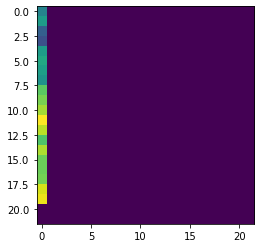

In [33]:
plt.imshow(meanBox)

In [34]:
import plotly.express as px
import plotly.graph_objs as go
fig = px.imshow(meanBox, color_continuous_scale="Viridis")
fig.show()

In [27]:
np.max(meanBox)

4.884263

In [106]:
pdXYZ[1]

{(3.0, 3.25): {0,
  2,
  8194,
  8197,
  5,
  8200,
  10,
  8205,
  16,
  8208,
  8210,
  8211,
  8212,
  8213,
  8214,
  23,
  24,
  8216,
  27,
  28,
  8219,
  30,
  8220,
  32,
  33,
  8221,
  8223,
  8225,
  8226,
  8229,
  39,
  8230,
  8231,
  43,
  44,
  45,
  46,
  8237,
  8239,
  49,
  8240,
  8241,
  53,
  8247,
  8248,
  57,
  58,
  59,
  8252,
  8253,
  8257,
  8258,
  8262,
  71,
  8263,
  8265,
  8268,
  77,
  8270,
  8273,
  83,
  8277,
  8278,
  89,
  90,
  8281,
  8282,
  93,
  97,
  8289,
  8294,
  104,
  8297,
  106,
  108,
  109,
  8302,
  8303,
  8306,
  8311,
  121,
  8313,
  124,
  8316,
  126,
  8317,
  8318,
  8319,
  8320,
  8321,
  8322,
  8325,
  134,
  8326,
  137,
  138,
  8329,
  142,
  8335,
  145,
  8337,
  147,
  149,
  8341,
  8346,
  8347,
  156,
  8350,
  8351,
  8352,
  8353,
  8357,
  8358,
  167,
  8361,
  8362,
  173,
  8365,
  177,
  178,
  8369,
  8371,
  8372,
  182,
  8374,
  184,
  185,
  8375,
  8377,
  8380,
  190,
  8383,
  193,
  8385,


In [156]:
pdXYZ.bounds

[[0.0, 5.25], [1.0, 30.5]]

In [153]:
pdXYZCap[1]

{(3.0, 3.25): {0.917192,
  1.285736,
  1.194547,
  2.74803,
  2.368195,
  2.333461,
  2.219628,
  1.172459,
  1.268148,
  2.032546,
  2.714485,
  2.414334,
  3.981866,
  5.005519,
  0.276541,
  2.642246,
  0.268692,
  1.323324,
  1.290498,
  0.542067,
  2.693551,
  2.729529,
  2.009383,
  0.034244,
  1.90139,
  0.563937,
  0.187361,
  0.505255,
  0.577934,
  0.78268,
  0.888903,
  1.381113,
  1.026362,
  0.795541,
  0.374729,
  2.593531,
  2.260588,
  0.635664,
  0.698164,
  1.154396,
  0.280965,
  0.499715,
  0.433719,
  0.2607,
  0.417541,
  0.458157,
  0.357678,
  0.303877,
  0.152939,
  1.944953,
  0.257078,
  0.310841,
  0.554321,
  0.613707,
  0.937142,
  0.616807,
  0.45745,
  0.113581,
  1.409037,
  1.104327,
  0.290199,
  0.762101,
  0.392906,
  0.758942,
  1.258942,
  0.685493,
  0.202686,
  0.216068,
  0.219531,
  1.669816,
  1.349481,
  1.33237,
  0.601095,
  2.082235,
  2.300985,
  0.679168,
  0.616668,
  1.611985,
  0.651018,
  0.75571,
  0.643169,
  2.807351,
  0.465054,

In [158]:
len(pdXYZCap[1].keys())

804

In [174]:
boxStatsCap={b:{pt:(np.mean(np.array(list(pdXYZCap[b][pt]),dtype=np.float32)),np.var(np.array(list(pdXYZCap[b][pt]),dtype=np.float32))) for pt in pdXYZCap[b].keys()} for b in pdXYZCap.img.keys()}
meanVars=[(pt,v) for pt,v in boxStatsCap[1].items()]
meanSortb1=sorted(meanVars,key=lambda x: x[1][0])[::-1]
meanSortb1[:100]

[((1.0, 1.5), (4.884263, 0.0)),
 ((1.75, 12.5), (4.477963, 0.0)),
 ((3.0, 7.25), (3.57249, 0.0)),
 ((1.25, 2.75), (3.04419, 0.0)),
 ((2.5, 14.0), (2.825789, 0.0)),
 ((2.25, 16.25), (2.820384, 0.0)),
 ((2.75, 13.25), (2.776057, 0.0064718667)),
 ((1.0, 1.75), (2.7678444, 0.908006)),
 ((2.25, 23.5), (2.696627, 0.0)),
 ((2.5, 13.75), (2.609018, 0.0)),
 ((2.25, 18.0), (2.605859, 0.0)),
 ((2.25, 18.75), (2.538835, 0.0)),
 ((2.5, 14.25), (2.5168948, 0.82313335)),
 ((2.5, 12.75), (2.455399, 3.0807846)),
 ((2.25, 14.75), (2.454554, 1.8955164)),
 ((2.25, 21.5), (2.445706, 0.0)),
 ((2.5, 13.5), (2.3783402, 1.8287733)),
 ((3.25, 7.0), (2.3566093, 8.26595)),
 ((2.25, 21.25), (2.306184, 0.0)),
 ((1.75, 12.25), (2.2944353, 1.6959174)),
 ((2.5, 12.0), (2.2909298, 0.361896)),
 ((2.5, 13.25), (2.2512667, 0.26901555)),
 ((2.5, 17.0), (2.230005, 0.0)),
 ((2.5, 15.5), (2.1458402, 0.0014616104)),
 ((2.75, 10.25), (2.068412, 0.0)),
 ((2.5, 11.5), (2.0573196, 0.9946103)),
 ((2.5, 11.75), (2.0063238, 0.9580182

In [177]:
pdXYZ[(2.75, 13.25)][1] | pdXYZ[(2.25, 16.25)][1] | pdXYZ[(2.5, 14.0)][1]
#df.loc[mofNames[12103]]

{1997, 3725, 4963, 5445}

In [178]:
sorted(meanVars,key=lambda x: x[0][0])

[((1.0, 1.75), (2.7678444, 0.908006)),
 ((1.0, 1.5), (4.884263, 0.0)),
 ((1.0, 1.25), (1.419396, 0.296919)),
 ((1.25, 2.5), (1.6804181, 0.65934944)),
 ((1.25, 2.0), (1.2696409, 0.8330598)),
 ((1.25, 2.25), (0.8998883, 0.6727991)),
 ((1.25, 1.5), (1.4435387, 1.3891102)),
 ((1.25, 1.75), (1.9493454, 1.9063101)),
 ((1.25, 1.25), (1.4332352, 1.7685373)),
 ((1.25, 2.75), (3.04419, 0.0)),
 ((1.25, 3.25), (1.603386, 0.0)),
 ((1.5, 2.5), (1.1328057, 0.9403)),
 ((1.5, 2.25), (1.0697204, 0.7992539)),
 ((1.5, 2.0), (1.039465, 0.70296246)),
 ((1.5, 5.75), (1.0020624, 0.7745888)),
 ((1.5, 3.5), (1.7557573, 1.4067287)),
 ((1.5, 3.75), (1.8870662, 1.9271157)),
 ((1.5, 4.0), (1.852096, 1.4971571)),
 ((1.5, 7.0), (0.47382626, 0.08324852)),
 ((1.5, 1.5), (1.6298383, 1.7029173)),
 ((1.5, 2.75), (1.2968899, 0.92278934)),
 ((1.5, 11.0), (0.36076, 0.0)),
 ((1.5, 8.0), (1.008966, 0.67636615)),
 ((1.5, 3.25), (1.6015096, 1.2006395)),
 ((1.5, 4.5), (1.5588021, 1.90834)),
 ((1.5, 5.0), (1.5206724, 1.1499681)),


In [168]:
pdXYZ.img[1][(7.75, 10.25)]

{9634, 10033}

In [164]:
boxStatsCap

{0: {(0.0, 1.0): (1.1063513, 0.91597),
  (0.0, 1.25): (1.0825393, 0.912285),
  (0.0, 1.5): (1.085653, 0.91195166),
  (0.0, 2.0): (1.0098932, 0.82958263),
  (0.0, 2.25): (1.252657, 1.0398195),
  (0.0, 1.75): (1.22365, 0.9821926),
  (0.0, 0.75): (1.3097321, 1.0498149),
  (0.0, 2.5): (1.3968364, 1.0322528),
  (0.0, 2.75): (1.207072, 1.0732851),
  (0.0, 3.0): (1.1155583, 0.7648363),
  (0.0, 3.5): (0.7157651, 0.16705935),
  (0.0, 4.25): (0.76563275, 0.05133375),
  (0.0, 5.0): (0.765085, 0.045788303),
  (0.0, 3.25): (1.0456198, 0.7307184),
  (0.0, 4.0): (0.83515376, 0.13471732),
  (0.0, 4.5): (0.33933523, 0.030716296),
  (0.0, 3.75): (0.7809976, 0.44241378),
  (0.0, 5.25): (0.6269785, 0.05306781),
  (0.0, 0.5): (1.354436, 2.496559),
  (0.0, 4.75): (0.42315865, 0.019358898)},
 1: {(3.0, 3.25): (1.132523, 0.7634964),
  (3.0, 3.0): (1.1167768, 0.83266675),
  (2.75, 3.0): (1.005519, 0.74514693),
  (2.0, 3.0): (0.97421724, 0.74250096),
  (2.0, 4.25): (0.8326966, 0.5803872),
  (1.5, 2.5): (1.13280

## For the first approach, Let's assume that we are given the bounds = [B0,B1,B2]
### then vectorize into bins, and pick the decision boundary by some func(prop)

ie. func(selectivity) -> $$

max_{bin} |\mu _{s,left}- \mu _{s,right} |$$

where we've created a binary projection (vs an intensity of bins -- <b>#todo</b>) in the left/right subtree for the mean of selectivity (s) of persistence diagrams which contain that bin (or intensity) vs those that don't.

Another binary implementation involves a modified func that accounts for the variance as well -- pros and cons



In [ ]:
bounds=[42,42,42] # if bounds are too big that's no good either, this naively requires exploratory anal
# we really want bounds = smallNum.+ [max(b0),max(b1),..] over all the datasets (distribution)



# Rather than discretizing the whole space and treating them independently in the decision factors, we'd like to
# either 1) make a sequence of cuts in b,d
# 2) Bayesian model
# 3) Find optimal decision, explore region around until loss grows, repeat
class pdDT:

    def __init__(self,):